# PhaseNet Example

Applying GaMMA to associate PhaseNet picks

In [1]:
# !pip install git+https://github.com/wayneweiqiang/GaMMA.git

In [2]:
import pandas as pd
from gamma.utils import association, estimate_eps
import numpy as np
import os
from pyproj import Proj
import json
import matplotlib.pyplot as plt


## 1. Download demo data

There are two examples in the demo data: Ridgecrest, CA and Chile.

**Phase Picks**:
- test_data/ridgecrest
    - picks.csv
    - stations.csv
    - standard_catalog.csv
- test_data/chile
    - picks.csv
    - stations.csv
    - iasp91.csv

**Results**:
- test_data/ridgecrest
    - gamma_events.csv
    - gamma_picks.csv
- test_data/chile
    - gamma_events.csv
    - gamma_picks.csv

In [3]:
# !if [ -f demo.tar ]; then rm demo.tar; fi
# !if [ -d test_data ]; then rm -rf test_data; fi
# !wget -q https://github.com/AI4EPS/GaMMA/releases/download/test_data/demo.tar
# !tar -xf demo.tar

In [4]:
# region = "ridgecrest"
# region = "chile"
region = "ncedc"
# test_name = "geyser"
test_name = "mtj"
data_path = lambda x: os.path.join(f"test_data/{region}", x)
result_path = f"results/{region}"
if not os.path.exists(result_path):
    os.makedirs(result_path)
result_path = lambda x: os.path.join(f"results/{region}", x)
station_csv = data_path("stations.csv")
station_json = data_path("stations.json")
if test_name == "geyser":
    picks_csv = data_path("picks_geyser.csv")
if test_name == "mtj":
    picks_csv = data_path("picks_mtj.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

In [5]:
## read picks
picks = pd.read_csv(picks_csv, parse_dates=["phase_time"])
picks = picks[['station_id', 'phase_time', 'phase_type', 'phase_score', 'phase_amplitude']]
if test_name == "geyser":
    picks = picks[(picks["phase_time"] >= "2023-03-02 21:15:00") & (picks["phase_time"] <= "2023-03-02 21:30:00")]
    # picks = picks[(picks["phase_time"] >= "2023-03-02 21:21:00") & (picks["phase_time"] <= "2023-03-02 21:24:00")]

picks.rename(columns={"station_id": "id", "phase_time": "timestamp", "phase_type": "type", "phase_score": "prob", "phase_amplitude": "amp"}, inplace=True)
print("Pick format:", picks.iloc[:3])

## read stations
# stations = pd.read_csv(station_csv)
# stations.rename(columns={"station_id": "id"}, inplace=True)
stations = pd.read_json(station_json, orient="index")
stations["id"] = stations.index
print("Station format:", stations.iloc[:3])

## Automatic region; you can also specify a region
with open(data_path("config.json"), "r") as f:
    config = json.load(f)
    config["center"] = ((config["minlongitude"] + config["maxlongitude"]) / 2, (config["minlatitude"] + config["maxlatitude"]) / 2)
    config["xlim_degree"] = (config["minlongitude"], config["maxlongitude"])
    config["ylim_degree"] = (config["minlatitude"], config["maxlatitude"])

# x0 = stations["longitude"].median()
# y0 = stations["latitude"].median()
# xmin = stations["longitude"].min()
# xmax = stations["longitude"].max()
# ymin = stations["latitude"].min()
# ymax = stations["latitude"].max()
# config = {}
# config["center"] = (x0, y0)
# config["xlim_degree"] = (2 * xmin - x0, 2 * xmax - x0)
# config["ylim_degree"] = (2 * ymin - y0, 2 * ymax - y0)

## projection to km
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x/1e3)
stations = stations[(stations["longitude"] > config["minlongitude"]) & (stations["longitude"] < config["maxlongitude"]) & (stations["latitude"] > config["minlatitude"]) & (stations["latitude"] < config["maxlatitude"])]
picks = picks[picks["id"].isin(stations["id"])]

### setting GMMA configs
config["use_dbscan"] = True
if region == "chile":
    config["use_amplitude"] = False
else:
    config["use_amplitude"] = True
config["method"] = "BGMM"  
if config["method"] == "BGMM": ## BayesianGaussianMixture
    config["oversample_factor"] = 5
if config["method"] == "GMM": ## GaussianMixture
    config["oversample_factor"] = 1

# config["covariance_prior"] = [1000.0, 1000.0]

# earthquake location
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["x(km)"] = proj(longitude=config["xlim_degree"], latitude=[config["center"][1]] * 2)[0]
config["y(km)"] = proj(longitude=[config["center"][0]] * 2, latitude=config["ylim_degree"])[1]

if region == "ridgecrest":
    config["z(km)"] = (0, 20)
elif region == "chile":
    config["z(km)"] = (0, 250)
else:
    config["z(km)"] = (0, 30)
    print("Please specify z(km) for your region")
    # raise NotImplementedError
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # z
    (None, None),  # t
)

# DBSCAN
config["dbscan_eps"] = 10 #estimate_eps(stations, config["vel"]["p"])
config["dbscan_min_samples"] = 3

## using Eikonal for 1D velocity model
if region == "ridgecrest":
    zz = [0.0, 5.5, 16.0, 32.0]
    vp = [5.5, 5.5,  6.7,  7.8]
    vp_vs_ratio = 1.73
    vs = [v / vp_vs_ratio for v in vp]
    h = 1.0
    vel = {"z": zz, "p": vp, "s": vs}
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
elif region == "chile":
    velocity_model = pd.read_csv(data_path("iasp91.csv"), names=["zz", "rho", "vp", "vs"])
    velocity_model = velocity_model[velocity_model["zz"] <= config["z(km)"][1]]
    vel = {"z": velocity_model["zz"].values, "p": velocity_model["vp"].values, "s": velocity_model["vs"].values}
    h = 1.0
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
else:
    print("Using uniform velocity model")

if region == "chile":
    config["initial_points"] = [1, 1, 1] # x, y, z

# set number of cpus
config["ncpu"] = 32

# filtering
config["min_picks_per_eq"] = 5
config["min_p_picks_per_eq"] = 0
config["min_s_picks_per_eq"] = 0
config["max_sigma11"] = 3.0*5 # second
config["max_sigma22"] = 1.0*3 # log10(m/s)
config["max_sigma12"] = 1.0*3 # covariance

## filter picks without amplitude measurements
if config["use_amplitude"]:
    picks = picks[picks["amp"] != -1]

for k, v in config.items():
    print(f"{k}: {v}")


Pick format:            id               timestamp type   prob       amp
0  BG.AL1..DP 2023-01-01 18:35:33.390    P  0.349  0.000007
1  BG.AL1..DP 2023-01-01 18:50:19.400    P  0.374  0.000001
2  BG.AL1..DP 2023-01-01 18:50:23.780    S  0.519  0.000001
Station format:            network station location instrument component  \
AZ.KNW..BH      AZ     KNW                  BH     12ENZ   
AZ.KNW..EH      AZ     KNW                  EH       12Z   
AZ.KNW..HH      AZ     KNW                  HH     12ENZ   

                                                  sensitivity  latitude  \
AZ.KNW..BH  [839091000.0, 209773000.0, 839091000.0, 209773...   33.7141   
AZ.KNW..EH  [31432900.0, 15716500.0, 31432900.0, 15716500....   33.7141   
AZ.KNW..HH  [157649000.0, 39412300.0, 840484000.0, 2101210...   33.7141   

            longitude  elevation_m  depth_km     x_km     y_km   z_km  \
AZ.KNW..BH  -116.7119       1507.0    -1.507  258.718 -416.537 -1.507   
AZ.KNW..EH  -116.7119       1507.0    -1.50

In [6]:
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [7]:
## Merge different instrument types
picks["id"] = picks["id"].apply(lambda x: ".".join(x.split(".")[:3])) # network.station.location.channel -> network.station.location
stations["id"] = stations["id"].apply(lambda x: ".".join(x.split(".")[:3])) # network.station.location.channel -> network.station.location
stations = stations.groupby("id").first().reset_index()


In [8]:
picks["t"] = (picks["timestamp"] - picks["timestamp"].min()).dt.total_seconds()
picks_filt = []
MIN_SECOND = 5 # minimum seconds between picks
for id, group in tqdm(picks.groupby("id")):
    db = DBSCAN(eps=MIN_SECOND, min_samples=1).fit(group[["t"]])
    labels = db.labels_
    for la in np.unique(labels):
        picks_filt.append(group[labels == la].sort_values("prob", ascending=False).iloc[0])

100%|██████████| 652/652 [00:03<00:00, 185.13it/s]


In [9]:
picks_filt = pd.DataFrame(picks_filt).reset_index(drop=True)
picks = picks_filt
stations = stations[["latitude", "longitude", "elevation_m", "id", "x(km)", "y(km)", "z(km)"]].reset_index(drop=True)

In [10]:
from sklearn.cluster import DBSCAN
import matplotlib.dates as mdates

In [11]:
picks_ = picks.merge(stations[["id", "x(km)", "y(km)", "z(km)", "longitude", "latitude"]], on="id")
picks_["t"] = (picks_["timestamp"] - picks_["timestamp"].min()).dt.total_seconds()
data = picks_[["t", "x(km)", "y(km)", "z(km)"]].values

vel = np.average(config["vel"]["p"])
db = DBSCAN(eps=config["dbscan_eps"], min_samples=config["dbscan_min_samples"]).fit(data[:, :3] / np.array([1, vel, vel]))
labels = db.labels_
unique_labels = set(labels)
unique_labels = unique_labels.difference([-1])

# lat0, lon0 = 40.409, -123.971  #MTJ
# lat0, lon0 = 38.821, -122.805
if test_name == "geyser":
    lat0, lon0 = 38.821, -122.805
if test_name == "mtj":
    lat0, lon0 = 40.409, -123.971

picks_["dist_km"] = np.sqrt((picks_["latitude"] - lat0)**2 + (picks_["longitude"] - lon0)**2) * 111.32
picks_["label"] = labels 
center = picks_.groupby("label").agg({"x(km)": "mean", "y(km)": "mean", "z(km)": "mean", "timestamp": "min", "latitude": "mean", "longitude": "mean"}).reset_index()
center["dist_km"] = np.sqrt((center["latitude"] - lat0)**2 + (center["longitude"] - lon0)**2) * 111.32



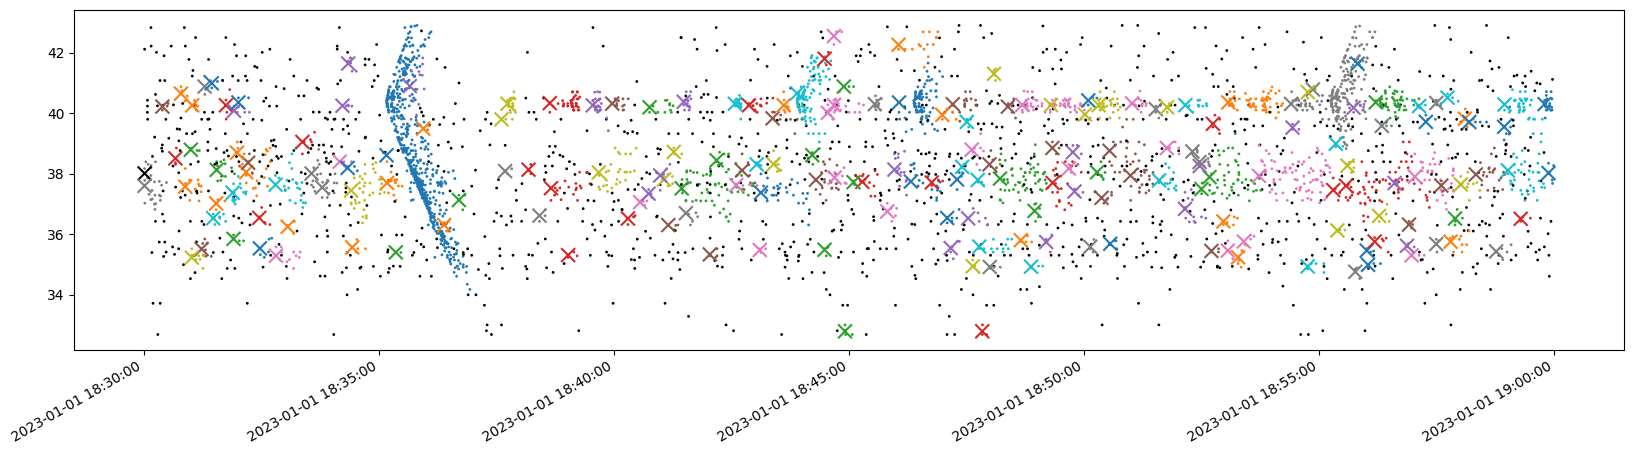

In [12]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["timestamp"], picks_["latitude"], c=picks_["label"].apply(mapping_color), s=1)
plt.scatter(center["timestamp"], center["latitude"], c=center["label"].apply(mapping_color), s=100, marker="x")
# plt set x time format to %Y-%m-%d %H:%M:%S
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()

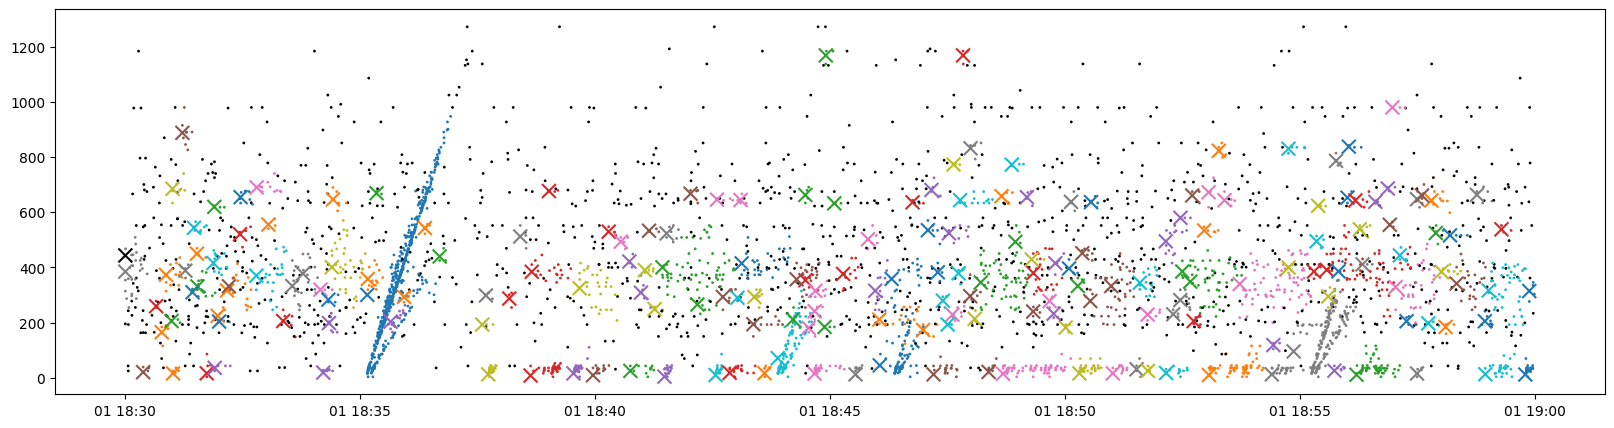

In [13]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["timestamp"], picks_["dist_km"], c=picks_["label"].apply(mapping_color), s=1)
plt.scatter(center["timestamp"], center["dist_km"], c=center["label"].apply(mapping_color), s=100, marker="x")

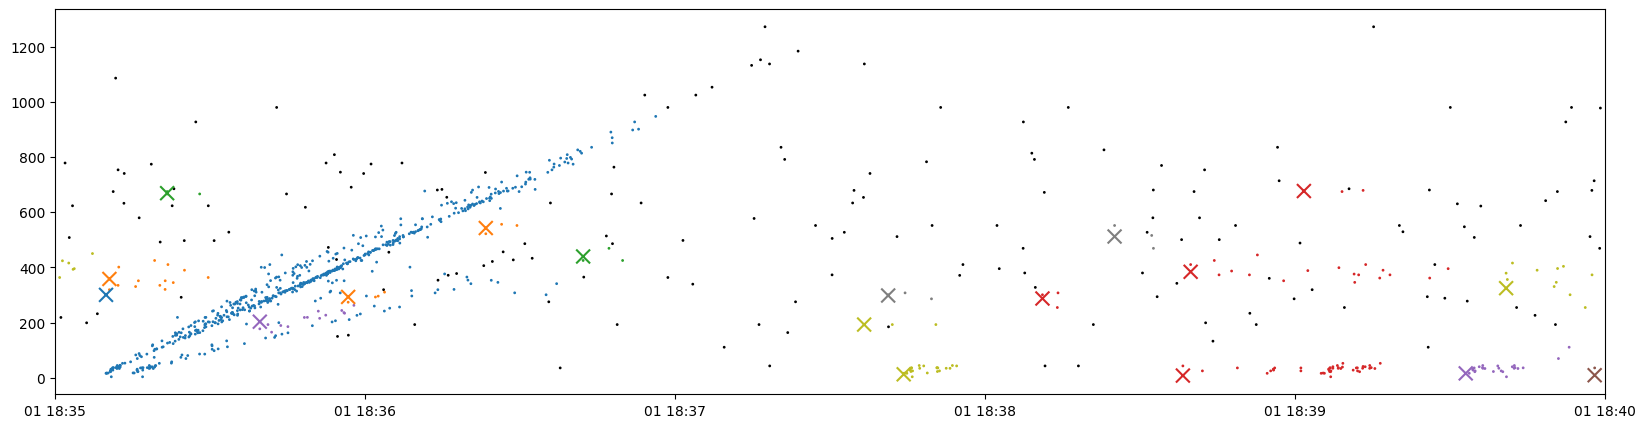

In [14]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["timestamp"], picks_["dist_km"], c=picks_["label"].apply(mapping_color), s=1)
plt.scatter(center["timestamp"], center["dist_km"], c=center["label"].apply(mapping_color), s=100, marker="x")
if test_name == "mtj":
    plt.xlim(pd.to_datetime("2023-01-01 18:35:00"), pd.to_datetime("2023-01-01 18:40:00"))
if test_name == "geyser":
    plt.xlim(pd.to_datetime("2023-03-02 21:15:00"), pd.to_datetime("2023-03-02 21:30:00"))

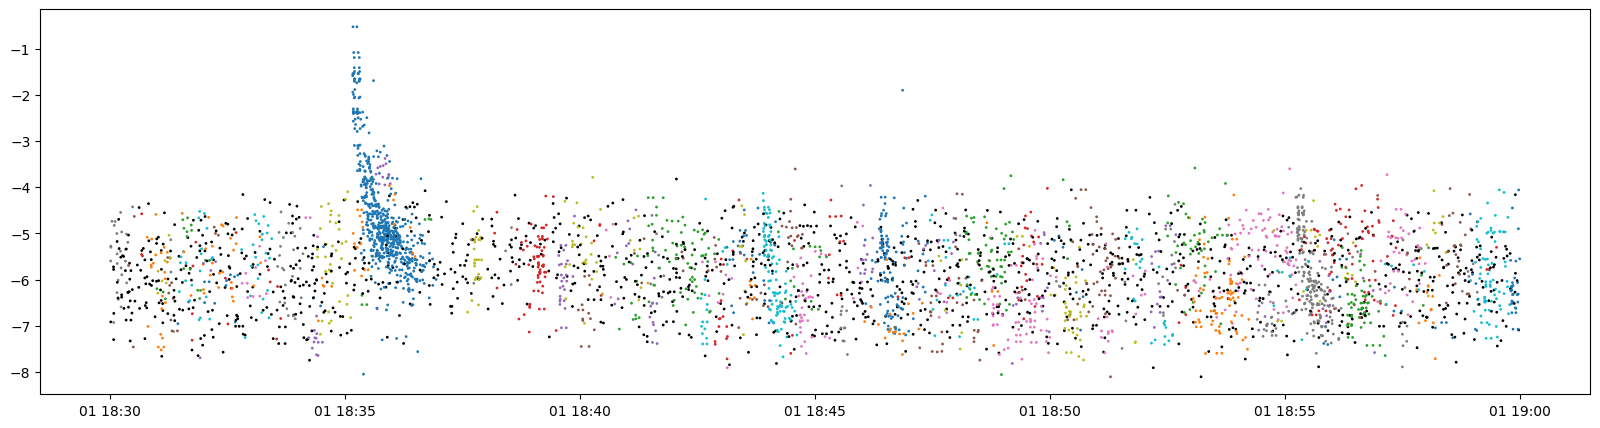

In [15]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["timestamp"], np.log10(picks_["amp"]), c=picks_["label"].apply(mapping_color), s=1)
# plt.scatter(center["timestamp"], center["dist_km"], c=center["label"].apply(mapping_color), s=100, marker="x")

## 2. Associaiton with GaMMA

In [16]:
for k, v in config.items():
    print(f"{k}: {v}")

minlatitude: 32
maxlatitude: 43
minlongitude: -125
maxlongitude: -114.0
num_nodes: 1
sampling_rate: 100
degree2km: 111.1949
channel: HH*,BH*,EH*,HN*
level: response
gamma: {'zmin_km': 0, 'zmax_km': 60}
cctorch: {'sampling_rate': 100, 'time_before': 0.25, 'time_after': 1.0, 'min_pair_dist_km': 10, 'components': 'ENZ123', 'component_mapping': {'3': 0, '2': 1, '1': 2, 'E': 0, 'N': 1, 'Z': 2}}
center: (-119.5, 37.5)
xlim_degree: (-125, -114.0)
ylim_degree: (32, 43)
use_dbscan: True
use_amplitude: True
method: BGMM
oversample_factor: 5
vel: {'p': 6.0, 's': 3.4285714285714284}
dims: ['x(km)', 'y(km)', 'z(km)']
x(km): (-486.29893938501783, 486.2989393850155)
y(km): (-610.6165417479444, 611.185297582399)
z(km): (0, 30)
bfgs_bounds: ((-487.29893938501783, 487.2989393850155), (-611.6165417479444, 612.185297582399), (0, 31), (None, None))
dbscan_eps: 10
dbscan_min_samples: 3
ncpu: 32
min_picks_per_eq: 5
min_p_picks_per_eq: 0
min_s_picks_per_eq: 0
max_sigma11: 15.0
max_sigma22: 3.0
max_sigma12: 3.

In [17]:
event_idx0 = 0 ## current earthquake index
assignments = []
events, assignments = association(picks, stations, config, event_idx0, config["method"])
event_idx0 += len(events)

## create catalog
events = pd.DataFrame(events)
events[["longitude","latitude"]] = events.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
events["depth_km"] = events["z(km)"]
events.to_csv(result_path("gamma_events.csv"), index=False, 
                float_format="%.3f",
                date_format='%Y-%m-%dT%H:%M:%S.%f')

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
picks.rename(columns={"id": "station_id", "timestamp": "phase_time", "type": "phase_type", "prob": "phase_score", "amp": "phase_amplitude"}, inplace=True)
picks.to_csv(result_path("gamma_picks.csv"), index=False, 
                date_format='%Y-%m-%dT%H:%M:%S.%f')

Associating 198 clusters with 16 CPUs
..................................................................................................................................................................................
Associated 100 events.
...................

In [18]:
if test_name == "mtj":
    lat0, lon0 = 40.409, -123.971
if test_name == "geyser":
    lat0, lon0 = 38.821, -122.805
picks = pd.read_csv(result_path("gamma_picks.csv"), parse_dates=["phase_time"]) 
events = pd.read_csv(result_path("gamma_events.csv"), parse_dates=["time"])
picks["id"] = picks["station_id"]
picks = picks.merge(stations[["id", "latitude", "longitude"]], on="id")
picks["dist_km"] = np.sqrt((picks["latitude"] - lat0)**2 + (picks["longitude"] - lon0)**2) * 111.32
events["dist_km"] = np.sqrt((events["latitude"] - lat0)**2 + (events["longitude"] - lon0)**2) * 111.32


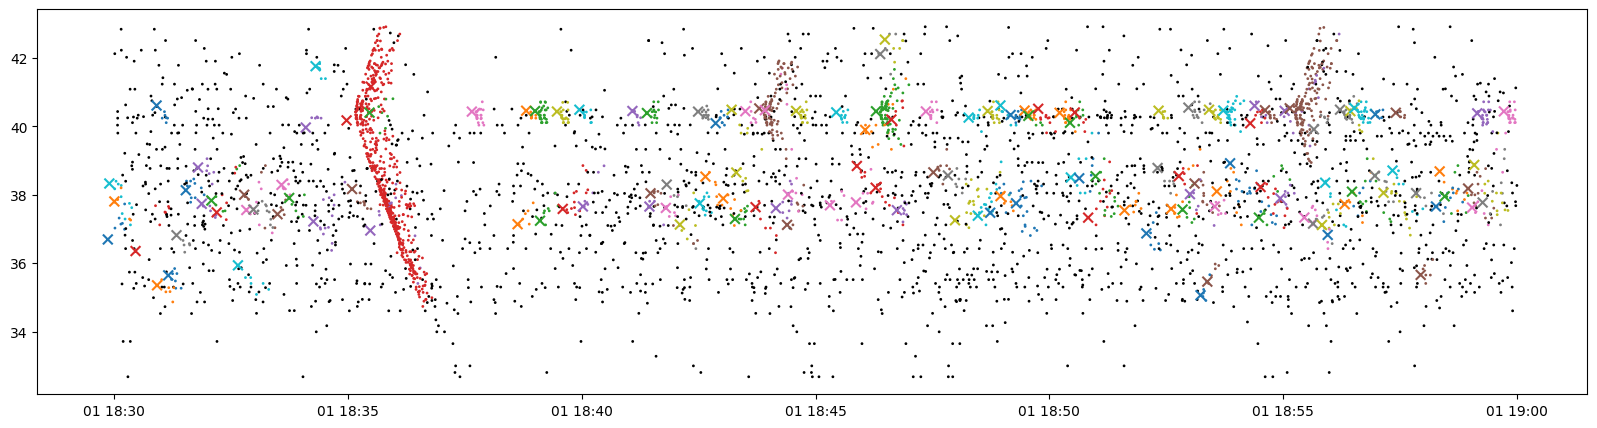

In [19]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks["phase_time"], picks["latitude"], c=picks["event_index"].apply(mapping_color), s=1)
plt.scatter(events["time"], events["latitude"], c=events["event_index"].apply(mapping_color), s=50, marker="x")

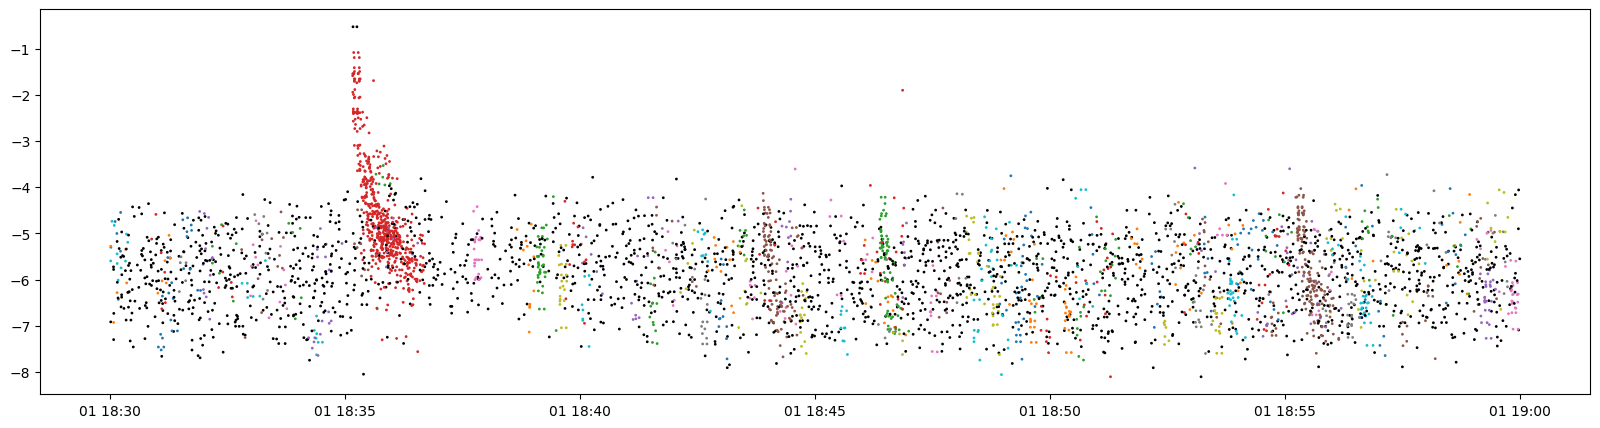

In [20]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks["phase_time"], np.log10(picks["phase_amplitude"]), c=picks["event_index"].apply(mapping_color), s=1)
# plt.scatter(events["time"], events["latitude"], c=events["event_index"].apply(mapping_color), s=50, marker="x")

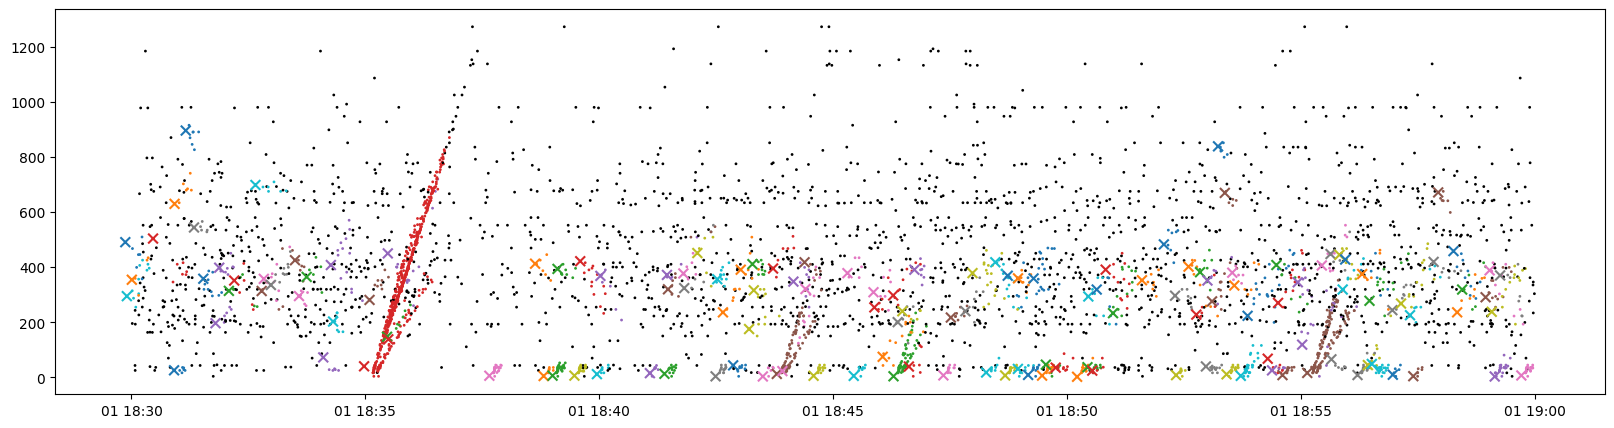

In [21]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks["phase_time"], picks["dist_km"], c=picks["event_index"].apply(mapping_color), s=1)
plt.scatter(events["time"], events["dist_km"], c=events["event_index"].apply(mapping_color), s=50, marker="x")

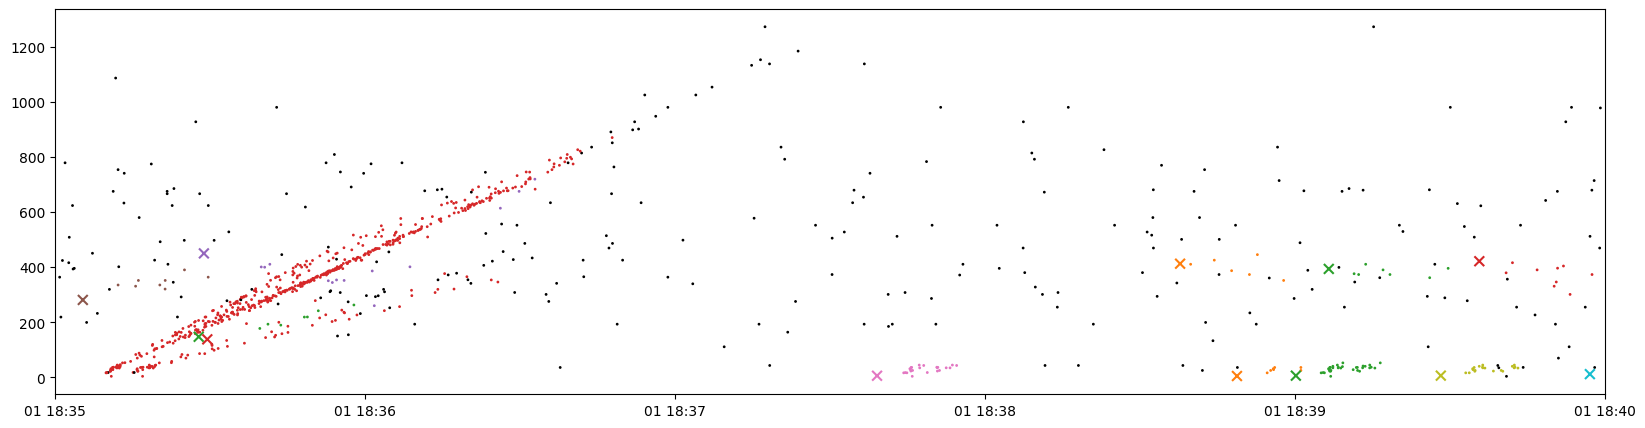

In [22]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks["phase_time"], picks["dist_km"], c=picks["event_index"].apply(mapping_color), s=1)
plt.scatter(events["time"], events["dist_km"], c=events["event_index"].apply(mapping_color), s=50, marker="x")
if test_name == "mtj":
    plt.xlim(pd.to_datetime("2023-01-01 18:35:00"), pd.to_datetime("2023-01-01 18:40:00"))

## 3. Filtering based on Nearest Station Ratio (Not required)

In [23]:
# %%
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd

events = pd.read_csv(result_path("gamma_events.csv"))
picks = pd.read_csv(result_path("gamma_picks.csv"))
# stations = pd.read_csv(data_path("stations.csv"))
stations = pd.read_json(station_json, orient="index")
stations["station_id"] = stations.index

MIN_NEAREST_STATION_RATIO = 0.1

# %%
stations["station_id"] = stations["station_id"].apply(lambda x: ".".join(x.split(".")[:3]))
stations = stations[stations["station_id"].isin(picks["station_id"].unique())]

neigh = NearestNeighbors(n_neighbors=min(len(stations), 10))
neigh.fit(stations[["longitude", "latitude"]].values)

# %%
picks = picks.merge(events[["event_index", "longitude", "latitude"]], on="event_index", suffixes=("", "_event"))
picks = picks.merge(stations[["station_id", "longitude", "latitude"]], on="station_id", suffixes=("", "_station"))

# %%
filtered_events = []
for i, event in tqdm(events.iterrows(), total=len(events)):
    sid = neigh.kneighbors([[event["longitude"], event["latitude"]]])[1][0]
    picks_ = picks[picks["event_index"] == event["event_index"]]
    # longitude, latitude = picks_[["longitude", "latitude"]].mean().values
    # sid = neigh.kneighbors([[longitude, latitude]])[1][0]
    stations_neigh = stations.iloc[sid]["station_id"].values
    picks_neigh = picks_[picks_["station_id"].isin(stations_neigh)]
    stations_with_picks = picks_neigh["station_id"].unique()
    if len(stations_with_picks) / len(stations_neigh) > MIN_NEAREST_STATION_RATIO:
        filtered_events.append(event)

# %%
print(f"Events before filtering: {len(events)}")
print(f"Events after filtering: {len(filtered_events)}")
filtered_events = pd.DataFrame(filtered_events)
os.system(f"mv {result_path('gamma_events.csv')} {result_path('gamma_events_raw.csv')}")
filtered_events.to_csv(result_path("gamma_events.csv"), index=False)


100%|██████████| 145/145 [00:00<00:00, 814.08it/s]

Events before filtering: 145
Events after filtering: 31


In [24]:
if test_name == "mtj":
    lat0, lon0 = 40.409, -123.971
if test_name == "geyser":
    lat0, lon0 = 38.821, -122.805
picks = pd.read_csv(result_path("gamma_picks.csv"), parse_dates=["phase_time"])
picks["id"] = picks["station_id"]
picks = picks.merge(stations[["station_id", "latitude", "longitude"]], on="station_id")
filtered_events = pd.read_csv(result_path("gamma_events.csv"), parse_dates=["time"])
picks["dist_km"] = np.sqrt((picks["latitude"] - lat0)**2 + (picks["longitude"] - lon0)**2) * 111.32
events["dist_km"] = np.sqrt((events["latitude"] - lat0)**2 + (events["longitude"] - lon0)**2) * 111.32
filtered_events["dist_km"] = np.sqrt((filtered_events["latitude"] - lat0)**2 + (filtered_events["longitude"] - lon0)**2) * 111.32
# picks = picks[picks["event_index"].isin(filtered_events["event_index"])]
# picks["event_index"] = picks["event_index"].apply(lambda x: -1 if x not in filtered_events["event_index"].values else x)
filtered_picks = picks[picks["event_index"].isin(filtered_events["event_index"])]

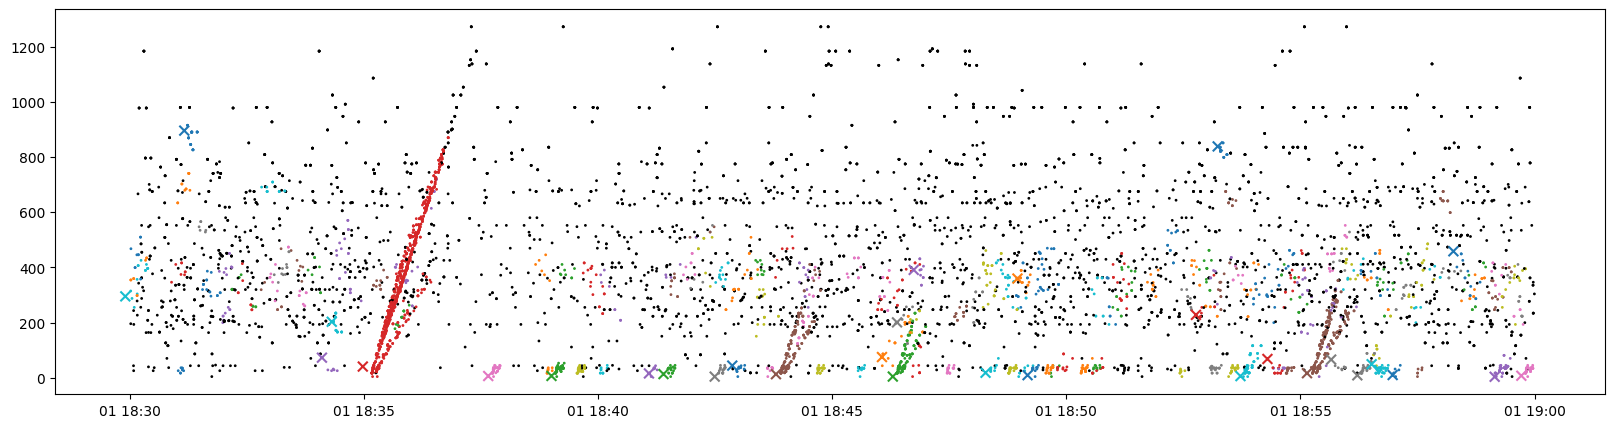

In [25]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks["phase_time"], picks["dist_km"], c=picks["event_index"].apply(mapping_color), s=1)
plt.scatter(filtered_events["time"], filtered_events["dist_km"], c=filtered_events["event_index"].apply(mapping_color), s=50, marker="x")

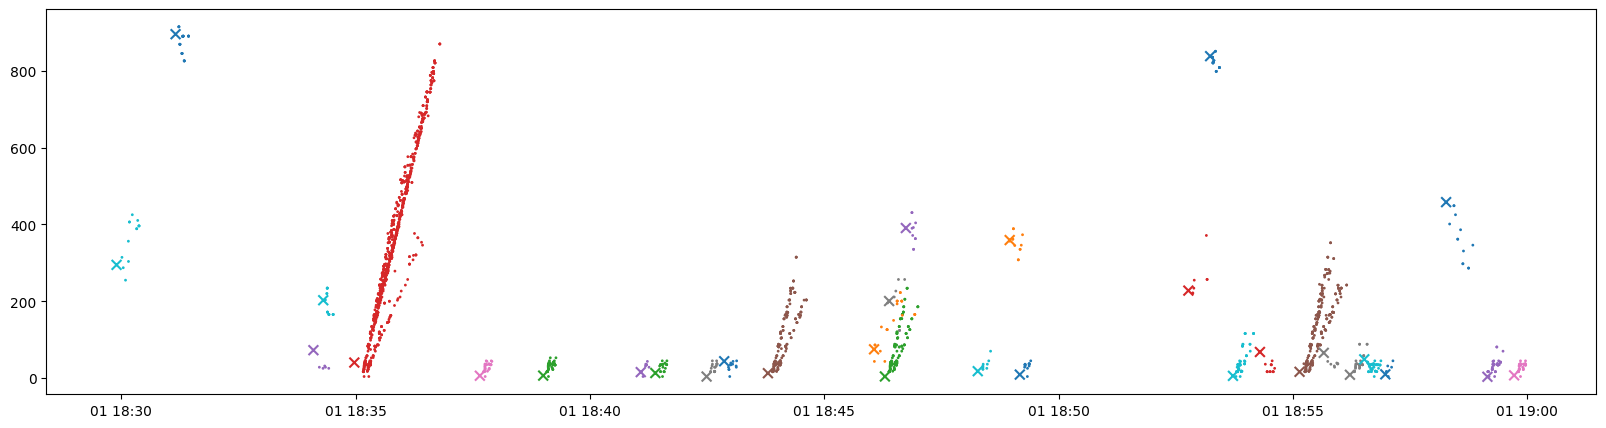

In [26]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(filtered_picks["phase_time"], filtered_picks["dist_km"], c=filtered_picks["event_index"].apply(mapping_color), s=1)
plt.scatter(filtered_events["time"], filtered_events["dist_km"], c=filtered_events["event_index"].apply(mapping_color), s=50, marker="x")

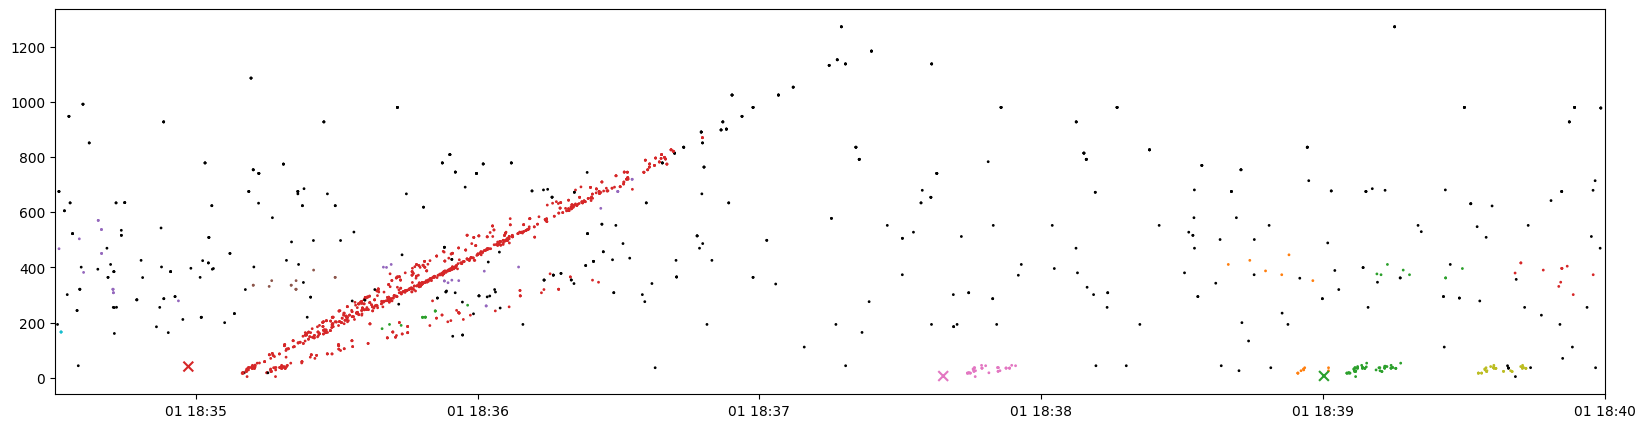

In [27]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks["phase_time"], picks["dist_km"], c=picks["event_index"].apply(mapping_color), s=1)
plt.scatter(filtered_events["time"], filtered_events["dist_km"], c=filtered_events["event_index"].apply(mapping_color), s=50, marker="x")
if test_name == "mtj":
    plt.xlim(pd.to_datetime("2023-01-01 18:34:30"), pd.to_datetime("2023-01-01 18:40:00"))


## 4. Visualize results

Note that the location and magnitude are estimated during associaiton, which are not expected to have high accuracy. 

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
result_label="GaMMA"
catalog_label="Standard"

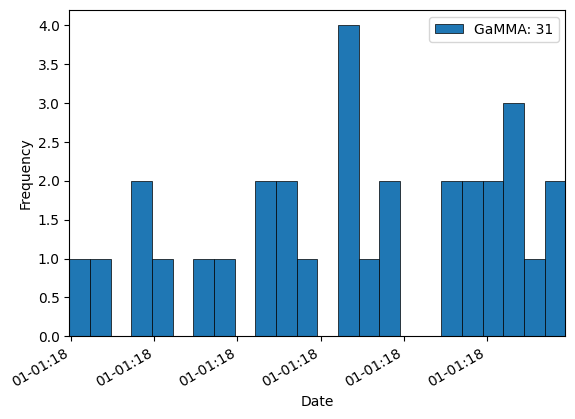

In [29]:
# stations = pd.read_csv(data_path("stations.csv"))
stations = pd.read_json(station_json, orient="index")
stations["id"] = stations.index
gamma_events = pd.read_csv(result_path("gamma_events.csv"), parse_dates=["time"])

if os.path.exists(data_path("standard_catalog.csv")):
    standard_catalog = pd.read_csv(data_path("standard_catalog.csv"), parse_dates=["time"])
    starttime = standard_catalog["time"].min()
    endtime = standard_catalog["time"].max()
else:
    standard_catalog = None
    starttime = gamma_events["time"].min()
    endtime = gamma_events["time"].max()


plt.figure()
plt.hist(gamma_events["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{result_label}: {len(gamma_events['time'])}")
if standard_catalog is not None:
    plt.hist(standard_catalog["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=0.6, linewidth=0.5, label=f"{catalog_label}: {len(standard_catalog['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(figure_dir("earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_number.pdf"), bbox_inches="tight")
plt.show();

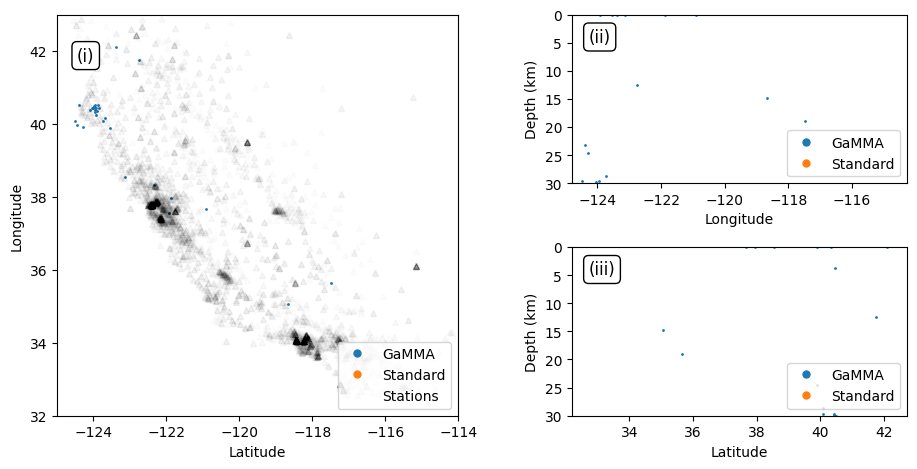

In [30]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(gamma_events["longitude"], gamma_events["latitude"], '.',markersize=2, alpha=1.0)
if standard_catalog is not None:
    plt.plot(standard_catalog["longitude"], standard_catalog["latitude"], '.', markersize=5, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))
plt.ylim(np.array(config["ylim_degree"]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}", rasterized=True)
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}", rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=5, alpha=0.01, label="Stations")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(gamma_events["longitude"], gamma_events["depth_km"], '.', markersize=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.plot(standard_catalog["longitude"], standard_catalog["depth_km"], '.', markersize=2, alpha=0.6, rasterized=True)
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.plot(gamma_events["latitude"], gamma_events["depth_km"], '.', markersize=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.plot(standard_catalog["latitude"], standard_catalog["depth_km"], '.', markersize=2, alpha=0.6, rasterized=True)
plt.xlim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(figure_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show();

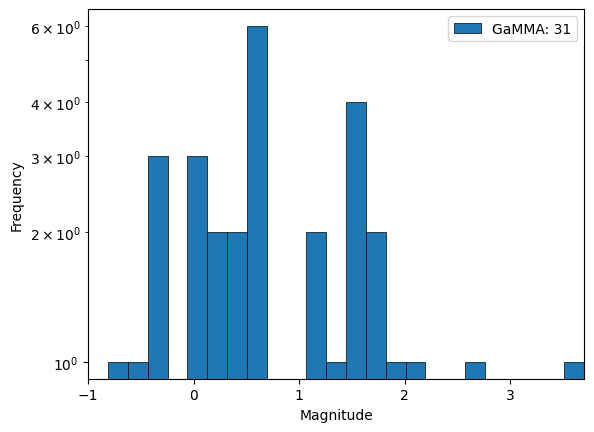

In [31]:
if standard_catalog is not None:
    range = (0, standard_catalog["magnitude"].max())
else:
    range = (-1, gamma_events["magnitude"].max())
if (gamma_events["magnitude"] != 999).any():
    plt.figure()
    plt.hist(gamma_events["magnitude"], range=range, bins=25, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{result_label}: {len(gamma_events['magnitude'])}")
    if standard_catalog is not None:
        plt.hist(standard_catalog["magnitude"], range=range, bins=25, alpha=0.6,  edgecolor="k", linewidth=0.5, label=f"{catalog_label}: {len(standard_catalog['magnitude'])}")
    plt.legend()
    if standard_catalog is not None:
        plt.xlim([0, standard_catalog["magnitude"].max()])
    else:
        plt.xlim([-1,gamma_events["magnitude"].max()])
    plt.xlabel("Magnitude")
    plt.ylabel("Frequency")
    plt.gca().set_yscale('log')
    plt.savefig(figure_dir("earthquake_magnitude_frequency.png"), bbox_inches="tight", dpi=300)
    plt.savefig(figure_dir("earthquake_magnitude_frequency.pdf"), bbox_inches="tight")
    plt.show();

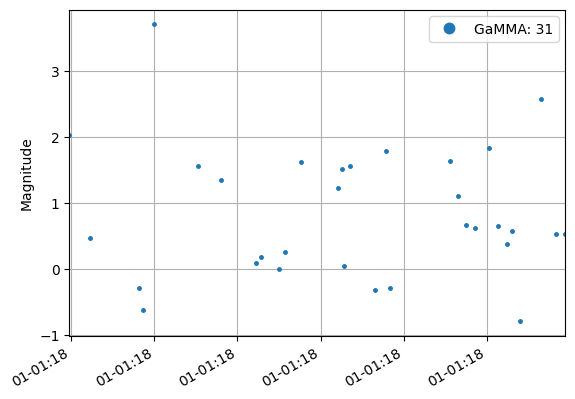

In [32]:
if (gamma_events["magnitude"] != 999).any():
    plt.figure()
    plt.plot(gamma_events["time"], gamma_events["magnitude"], '.', markersize=5, alpha=1.0, rasterized=True)
    if standard_catalog is not None:
        plt.plot(standard_catalog["time"], standard_catalog["magnitude"], '.', markersize=5, alpha=0.8, rasterized=True)
    plt.xlim([starttime, endtime])
    ylim = plt.ylim()
    plt.ylabel("Magnitude")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    plt.gcf().autofmt_xdate()
    plt.gca().set_prop_cycle(None)
    plt.plot([],[], '.', markersize=15, alpha=1.0, label=f"{result_label}: {len(gamma_events['magnitude'])}")
    if standard_catalog is not None:
        plt.plot([],[], '.', markersize=15, alpha=1.0, label=f"{catalog_label}: {len(standard_catalog['magnitude'])}")
    plt.legend()
    plt.ylim(ylim)
    plt.grid()
    plt.savefig(figure_dir("earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
    plt.savefig(figure_dir("earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
    plt.show();

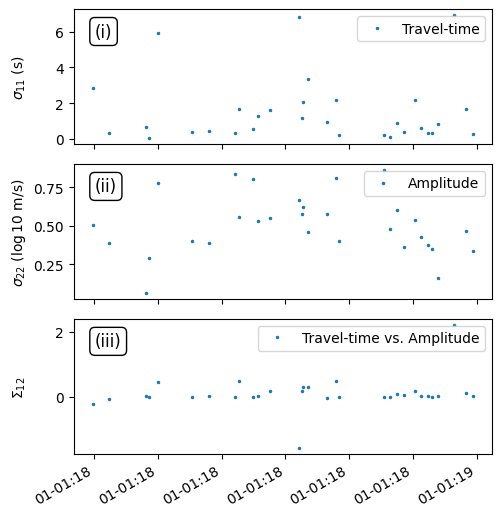

In [33]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([0.8,1.1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.plot(gamma_events["time"], gamma_events["sigma_time"], '.', markersize=3.0, label="Travel-time")
plt.ylabel(r"$\sigma_{11}$ (s)")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(312)
plt.plot(gamma_events["time"], gamma_events["sigma_amp"], '.', markersize=3.0, label="Amplitude")
plt.ylabel(r"$\sigma_{22}$ ($\log10$ m/s)")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(313)
plt.plot(gamma_events["time"], gamma_events["cov_time_amp"], '.', markersize=3.0, label="Travel-time vs. Amplitude")
plt.ylabel(r"$\Sigma_{12}$")
# plt.ylim([-0.5, 0.5])
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig(figure_dir("covariance.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("covariance.pdf"), bbox_inches="tight")
plt.show();